<a href="https://colab.research.google.com/github/sumitwalke/Brain-Tumour-Classification-/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow # imports the TensorFlow library.
from PIL import Image #used for loading and saving images.
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array  #used for loading, saving, and converting images to NumPy arrays.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input  #pre-trained model for image classification
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, GlobalAveragePooling2D
import cv2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import os
import itertools
import imutils
from sklearn.model_selection import StratifiedGroupKFold
import random
from tensorflow.keras import layers
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive

MyDrive


# Sample Images


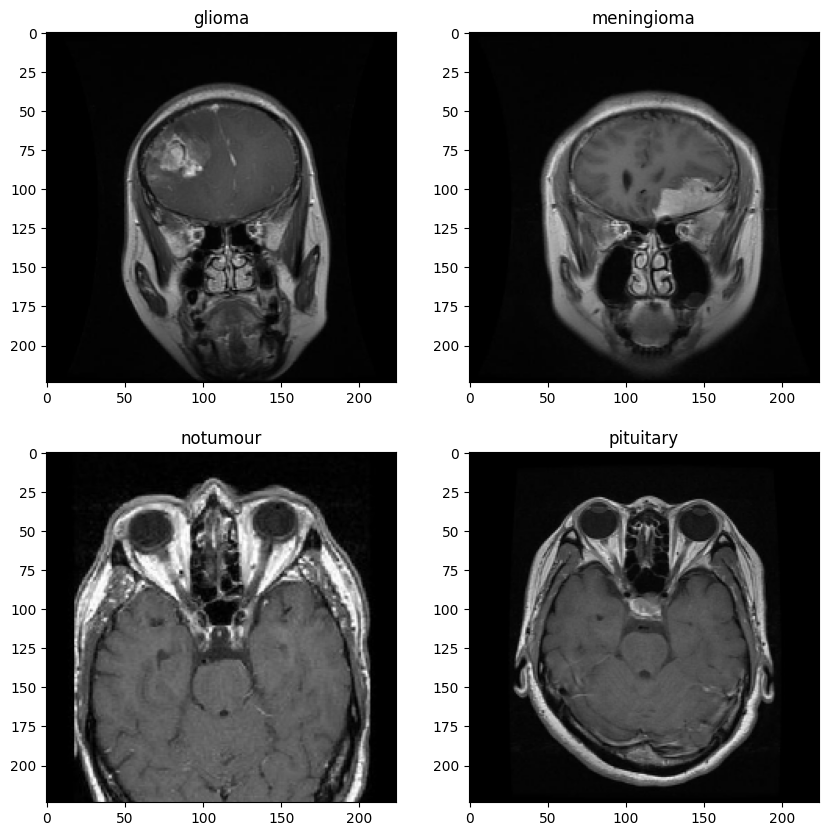

In [ ]:
import matplotlib.pyplot as plt
import cv2

data_dir = ('/content/drive/MyDrive/brain_tumour')
categories = ['glioma', 'meningioma', 'notumour', 'pituitary']
plt.figure(figsize = (10, 10))

images_path = ['/Training/glioma/Tr-glTr_0000.jpg', '/Training/meningioma/Tr-meTr_0000.jpg', '/Training/notumor/Tr-noTr_0000.jpg', '/Training/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])

    if img is None:
      print('Could not find the image')
      exit(0)
    else:
      img = cv2.resize(img, (224, 224))
      plt.imshow(img)
      plt.title(categories[i])

# Cropping Images


In [ ]:
from cv2.gapi import threshold   #for faster image processing
def crop_img(img):

  #Finds the extreme points on the image and crops the rectangular out of it
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  #Coverting the image to grayscale
  gray = cv2.GaussianBlur(gray, (3, 3), 0)  # Smoothing the images

  # threshold the image, then perform a series of erosions
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1] #Thresholding is applied to create a binary image (thresh)

  #Eroding and Dilating to remove small regions of noise common process for cleaning up binary images.
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

	# find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

In [ ]:
img = cv2.imread('/content/drive/MyDrive/brain_tumour/Training/meningioma/Tr-meTr_0009.jpg')
img = cv2.resize(
    img,
    dsize = (224,224),
    interpolation = cv2.INTER_CUBIC #Geometric Transformation into a articular size
)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)

#threshold the image, then perform a series of erosions
#dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]  #Thresholding is applied to create a binary image (thresh)
thresh = cv2.erode(thresh, None, iterations = 2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
#contours are curves that connect points of equal value in a function.
# They can be used to visualize the output of a machine learning model,
# and to identify areas where the model is uncertain or making mistakes.
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


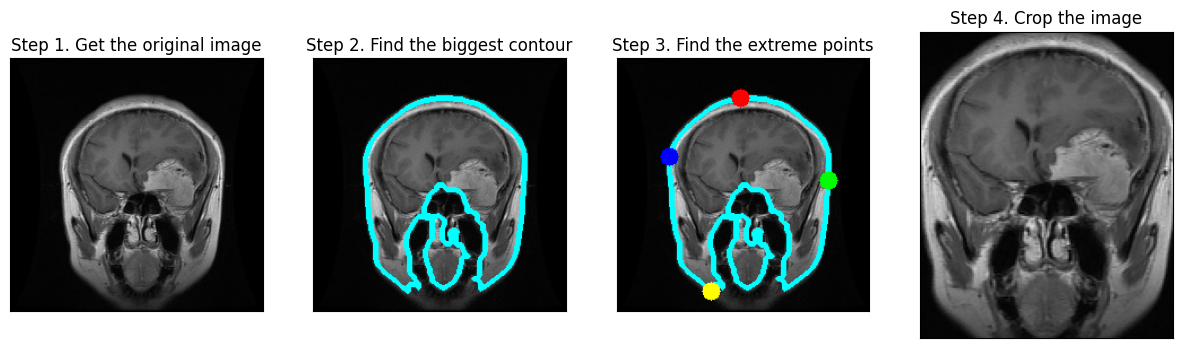

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('/content/drive/My Drive/brain_tumour/cropped/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.

        # The bone colormap is a grayscale colormap that is often used in medical imaging to visualize data. It is a sequential colormap,
        # meaning that it progresses from black to white. The bone colormap is useful for visualizing data that has a wide range of values,
        # as it can help to highlight subtle differences in the data.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join('/content/drive/My Drive/brain_tumour/cropped/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) # normalize Images into range 0 to 1.
x_test = np.array(x_test)

print(x_train.shape)
print(x_test.shape)

100%|██████████| 300/300 [00:03<00:00, 75.86it/s] 


(5901, 200, 200, 3)
(1311, 200, 200, 3)


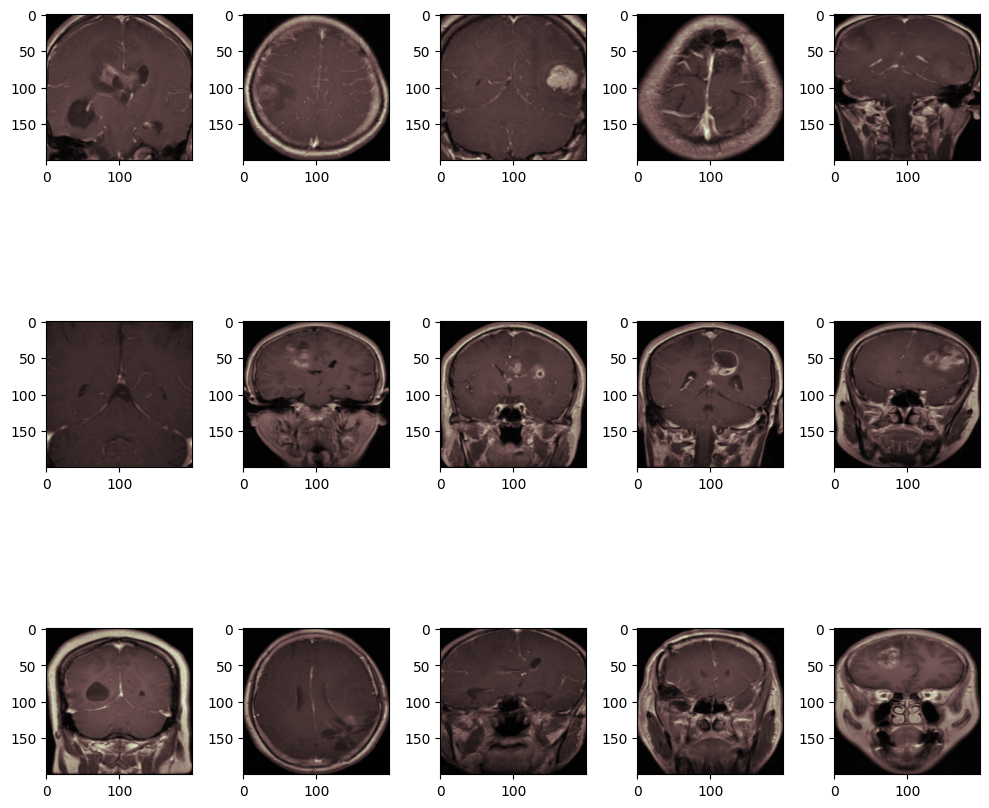

In [ ]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=42)

y_train = tensorflow.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels This section converts the categorical labels into one-hot encoded vectors.
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)

(1181, 200, 200, 3)


# Image Augmentation

In [ ]:
# set the paramters we want to change randomly
#ImageDataGenerator is used for data augmentation,
# which helps to improve the model's generalization.
from keras.preprocessing.image import ImageDataGenerator
import os
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

os.mkdir('preview_2')
x = x_train[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview_2', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
# ResNet50 is a convolutional neural network (CNN) architecture ,It is a 50-layer CNN
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# The first line of code, model = conv_base.output, creates a new
# model that takes the output of the pre-trained CNN as its input.
#  The next line of code, model = GlobalAveragePooling2D()(model),
#  performs global average pooling on the output of the pre-trained CNN.
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# The callbacks you provided are used to save the best model during training and
# reduce the learning rate if the model is not improving.
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [ ]:
train_len = len(x_train)
val_len = len(x_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
4720
-----------Validation Data length-----------------
1181


In [ ]:
# The line of code you provided trains the model and returns a history object.
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),validation_data = (x_val,y_val),epochs = 20,callbacks = callbacks)

Epoch 1/20
74/74 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.8807
Epoch 1: val_loss improved from inf to 0.41488, saving model to .mdl_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


74/74 [==============================] - 115s 958ms/step - loss: 0.3092 - accuracy: 0.8807 - val_loss: 0.4149 - val_accuracy: 0.8298 - lr: 1.0000e-04
Epoch 2/20
74/74 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9701
Epoch 2: val_loss did not improve from 0.41488
74/74 [==============================] - 60s 813ms/step - loss: 0.0819 - accuracy: 0.9701 - val_loss: 0.5665 - val_accuracy: 0.8467 - lr: 1.0000e-04
Epoch 3/20
74/74 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9788
Epoch 3: val_loss improved from 0.41488 to 0.29006, saving model to .mdl_wts.hdf5
74/74 [==============================] - 66s 888ms/step - loss: 0.0633 - accuracy: 0.9788 - val_loss: 0.2901 - val_accuracy: 0.9314 - lr: 1.0000e-04
Epoch 4/20
74/74 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9864
Epoch 4: val_loss improved from 0.29006 to 0.11743, saving model to .mdl_wts.hdf5
74/74 [==============================] - 67s 904ms/step - l

# Learning Curves

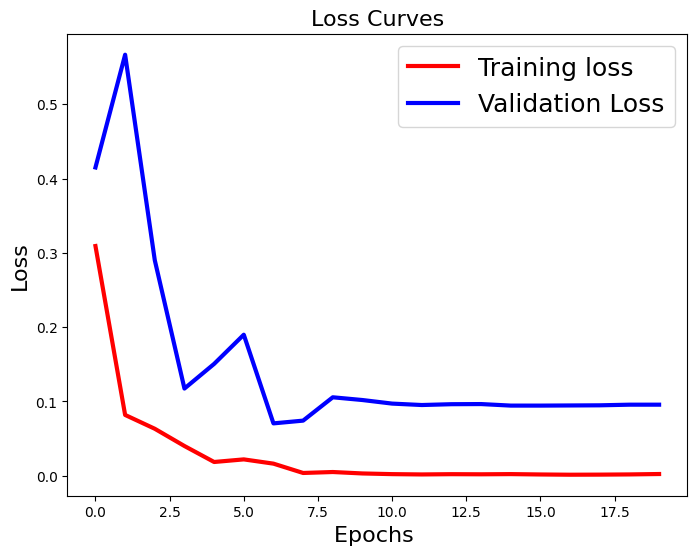

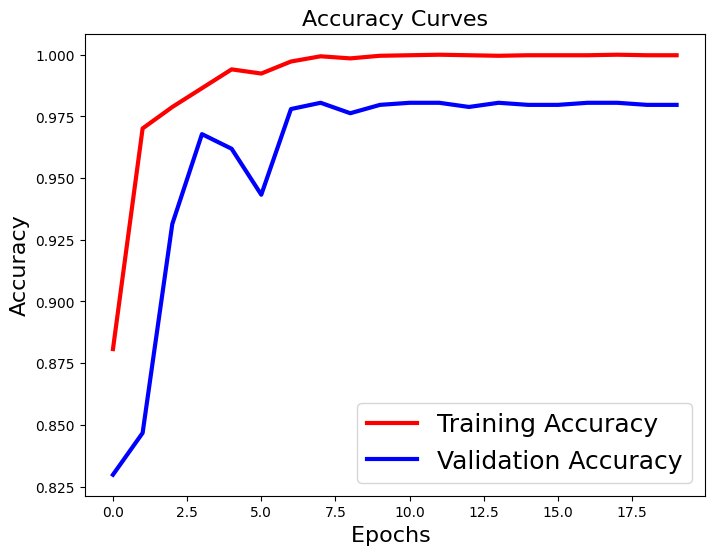

In [ ]:
#Plot the Loss Curves
# The loss is a measure of how well the model's predictions match the actual data.
# A lower loss indicates that the model is making better predictions.
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()


#Plot the Accuracy Curves
# The accuracy is the percentage of predictions that the model makes correctly.
# A higher accuracy indicates that the model is making more accurate predictions.
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()


# Loading Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('.mdl_wts.hdf5')
model.save('/content/drive/My Drive/brain_tumour/modelres50.h5')

model = load_model('/content/drive/My Drive/brain_tumour/modelres50.h5')

# Validation on Test Set

In [ ]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 3s 84ms/step - loss: 0.0460 - accuracy: 0.9870


In [ ]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(x_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma', 'meningioma', ' no_tumor', 'pituitary']))

41/41 [==============================] - 4s 79ms/step
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      0.97      0.98       306
    no_tumor       0.97      1.00      0.99       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



164/164 [==============================] - 4s 25ms/step


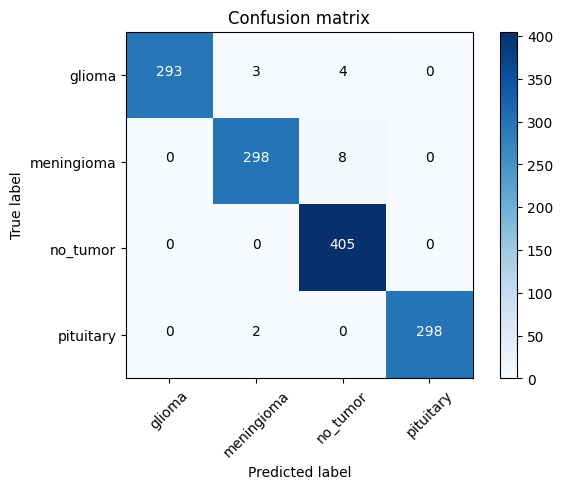

In [ ]:

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=8)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y,axis = 1)
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)



# plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = range(4))


82/82 [==============================] - 5s 49ms/step


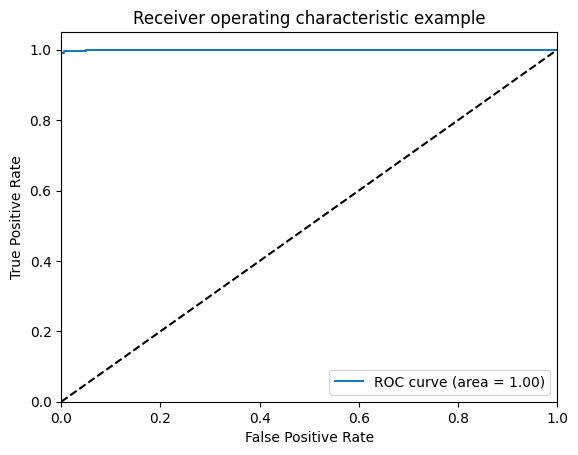

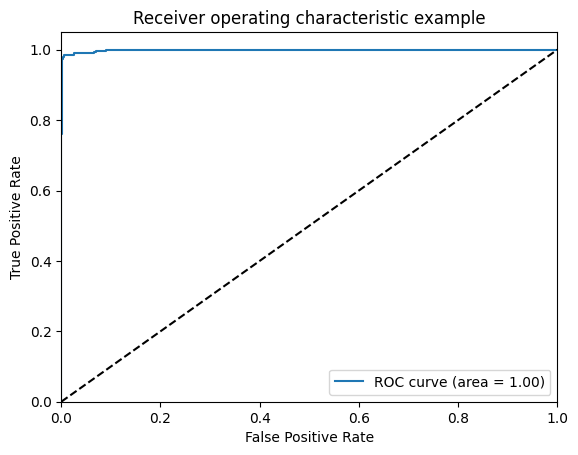

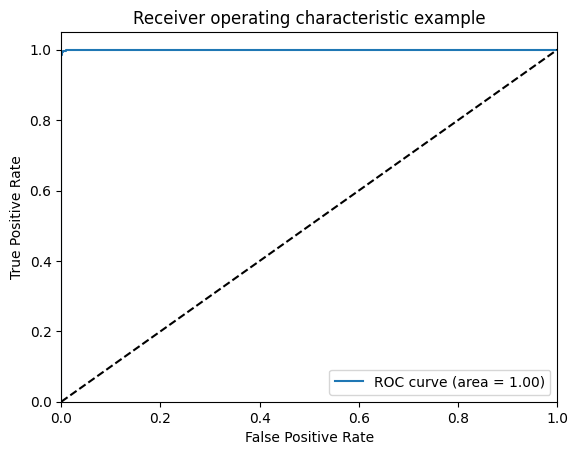

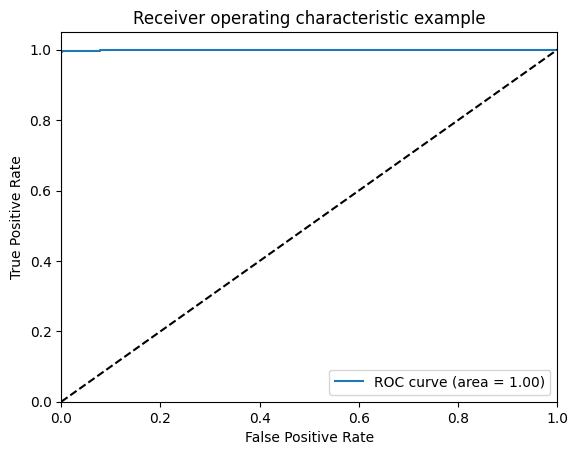

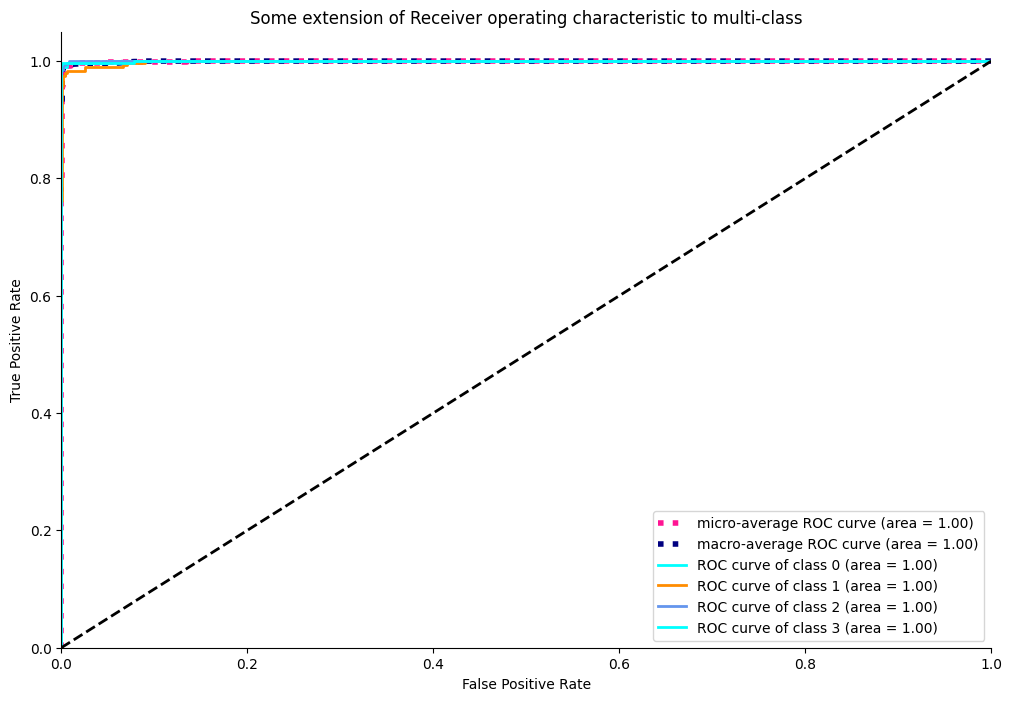

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_test = np.array(y_test)

n_classes = 4

pred_Y = model.predict(x_test, batch_size = 16, verbose = True)
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    # plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
sns.despine()
# plt.show()

# Plotting sample predictions

41/41 [==============================] - 3s 79ms/step


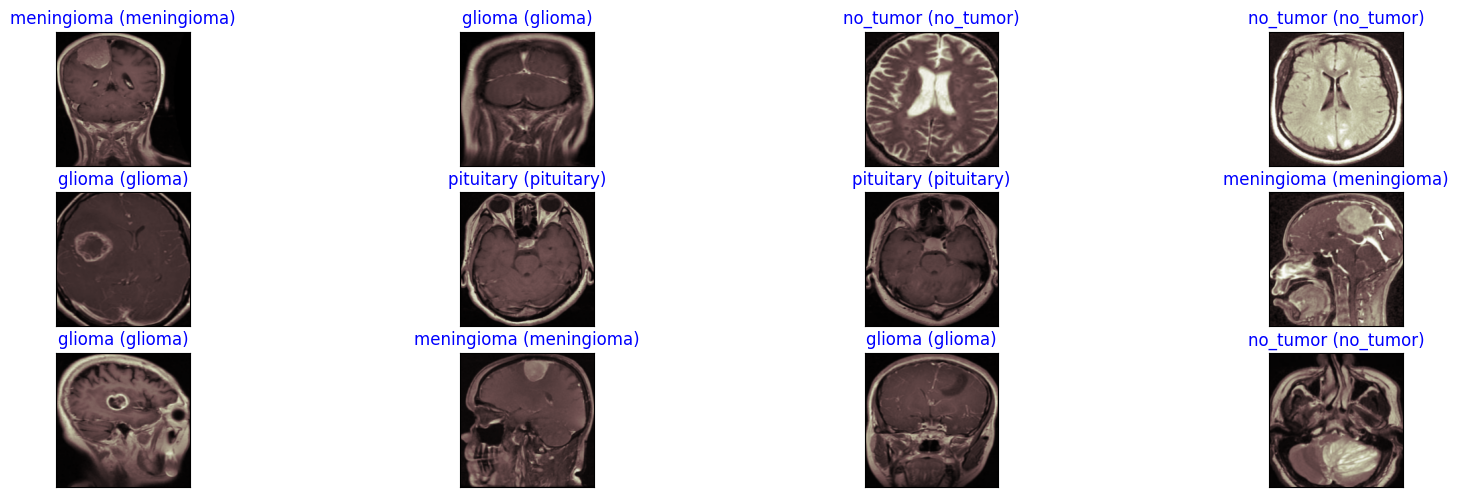

In [ ]:
y_hat = model.predict(x_test)

# define text labels
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(4,4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))